In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
import gym

# 建立 Policy Gradient 模型

In [2]:
class PolicyGradient:
    
    def __init__(
        self, 
        n_actions, 
        n_states, 
        gamma = 0.9,            # 遠見程度
        epsilon = None,         # 保守程度，值越大就越容易用Q值大小來採取行動；值越小則越容易產生隨機行動
        epsilon_increase = None,
        learning_rate = 0.001,  # 神經網路的更新率
        neuron_num = 10
    ):
        # 初始化變數值
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        self.lr = learning_rate
        self.neuron_num = neuron_num
        
        # 初始化記憶庫
        self.past_state, self.past_action, self.past_reward = [], [], []
        # one hot encoding for saving actions
        self.action_one_hot = np.zeros(self.n_actions, dtype=np.int32)

        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() ## 宣告session
        
        # 輸入 current state
        self.state_input = tf.placeholder(shape=[None, self.n_states], name='state_input', dtype = tf.float32)
        
        """
        輸入 real action 和神經網路的 output 
        act_proba 算 cross entropy 當作更新方向
        以超級瑪莉的遊戲為例 action = [上, 下, 左, 右]
        如果實際action為向左則，action = [0, 0, 1, 0]。
        也可以將這四個動作用 0, 1, 2 ,3 代表，如此的話只需要用一維來存取動作，
        也就是輸入shape = [None, 1]，那後面再算 cross entropy 的話就要用tf.nn.sparse_softmax_cross_entropy_with_logits，
        大家也可以試著改寫看看。
        """    
        self.real_action = tf.placeholder(shape=[None, self.n_actions], name = 'real_action', dtype = tf.float32)
        """
        但是有時候產生的動作會帶來好的效果或壞的效果並且程度不一，因此 loss 不能光用神經網路的
        輸出 action_proba 和 real action 的 cross entropy 代表，因此這邊乘上 action_reward 來校正loss。
        例如某個動作很有幫助那必然會產生很大的 action_reward，因此乘上很大的 action_reward 即可加大 loss 
        讓此動作之後產生的機率被放大；相反的，某個動作如果產生很好的效果反而會帶來負的 action_reward 使得loss變負的，
        讓更新方向相反使得之後輸出此動作的機會減少。
        """
        self.Vt = tf.placeholder(shape= [None, ], name="Vt", dtype = tf.float32)
        
        # 搭建神經網路
        with tf.variable_scope('actor'):
            self.act_proba = self.build_network(self.neuron_num, trainable=True, scope='net_eval')
        
        # 管理神經網路的 parameters
        self.actor_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor/net_eval')
        
        # loss
        """
        算出 "神經網路輸出的動作機率" 與 "實際動作" 的 cross entropy 當作 loss，但是更新的方向和力道就利用
        action reward 來決定。例如，這一回合產生的所有動作組合如果得到很好的 reward，那就應該讓神經網路的
        輸出機率更靠近實際輸出的結果，因此 cross_entropy 和 action_reward 相乘得到的 loss 就更大，更新力度就更大。
        相反的，這一回合產生的所有動作組合如果得到負的 reward，那就應該讓神經網路輸出動作的機率更遠離實際輸出結果，
        在這樣的狀況下，cross_entropy 和 action_reward 相乘得到的 loss 就會得到負的，神經網路的參數更新方向就會往反方向。
        """
        self.cross_entropy = tf.reduce_sum(-tf.log(self.act_proba)*self.real_action, axis=1)
        self.loss = tf.reduce_sum(self.cross_entropy*self.Vt)
 
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.actor_eval_params)
    
        self.sess.run(tf.global_variables_initializer()) # 將神經網路初始化
    
    def write_memory(self, current_state, reward, action):
        action_one_hot = self.action_one_hot.copy()
        action_one_hot[action] = 1
        
        self.past_state.append(current_state)
        self.past_action.append(action_one_hot)
        self.past_reward.append(reward)
    
    def build_network(self, neuron_num, trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            x_h1 = tf.layers.dense(inputs=self.state_input, units=neuron_num, activation=tf.nn.tanh,
                                   kernel_initializer=init_w, bias_initializer=init_b, trainable=trainable) 
            x_h2 = tf.layers.dense(inputs=x_h1, units=neuron_num, activation=tf.nn.tanh,
                                   kernel_initializer=init_w, bias_initializer=init_b, trainable=trainable)
            
            # 輸出為下個行動的機率，因此使用 softmax
            output = tf.layers.dense(inputs=x_h2, units=self.n_actions, activation=tf.nn.softmax,
                                     kernel_initializer=init_w, bias_initializer=init_b, trainable=trainable)
        
        return output # 輸出 "不同動作" 對應的機率值
    
    def choose_action(self, current_state):
        act_proba = self.sess.run(self.act_proba, feed_dict={ self.state_input: current_state[np.newaxis, :] })
        """
        根據神經網路輸出下個動作的機率當作權重做隨機抽樣選出動作。一樣舉超級瑪莉的例子，如果輸出
        [上, 下, 左, 右] 的機率分別為 [0.3, 0.1, 0.2, 0.4]，那做隨機抽樣就分別有 30%, 10%, 
        20% 和 40% 的機率抽到上、下、左、右，因為這樣的做法已具有隨機性因此不需要用 epsilon 來控制
        行為的隨機程度來增加探索。
        """
        self.action = np.random.choice(range(act_proba.shape[1]), p=act_proba.ravel())  
   
        return self.action
        
    def learn(self): 
        # 用 reward 算出更新向量
        Vt = self.calculate_Vt()

        # 將整個 episode 的資料放進來做更新
        self.sess.run(self.train, feed_dict={
            self.state_input: np.vstack(self.past_state),  # shape=[None, n_state]
            self.real_action: np.array(self.past_action),  # shape=[None, n_actions]
            self.Vt: np.array(Vt)                          # shape=[None, ]
        })
        # 更新完後將記憶庫清空
        self.past_state, self.past_action, self.past_reward = [], [], []    
    
    def calculate_Vt(self):
        # discount episode rewards
        Vt = np.zeros_like(self.past_reward, dtype=np.float64)
        
        Vt_temp = 0
        for t in reversed(range(0, len(self.past_reward))):
            Vt_temp = self.past_reward[t] + Vt_temp * self.gamma
            Vt[t] = Vt_temp

        # normalize episode rewards
        Vt -= np.mean(Vt)
        Vt /= np.std(Vt)
        
        return Vt
        
    def model_save(self, model_name):
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))

In [4]:
def training(save_model, model_name):
    step_record = []
    #dead_record = []
    for episode in range(100):
        # 初始化環境並取得起始的狀態
        current_state = env.reset()
        
        step = 0
        total_reward = 0
        while True:
            # 產生環境視窗
            env.render()

            # 根據現在的狀態選擇動作
            action = RL.choose_action(current_state)

            # 產生動作和環境互動後產生下一個狀態、獎勵值及遊戲是否結束
            next_state, reward, done, _ = env.step(action)
            
            total_reward += reward
                        
            # 將資訊存至記憶體中以便進行 experience replay
            RL.write_memory(current_state, reward, action)
            
            #if reward < 0 :
            #    dead+=1
            # swap state
            current_state = next_state

            # break while loop when end of this episode
            if done or total_reward > 50000:
                RL.learn()
                print('episode:{} steps:{} total_reward:{}'.format(episode, step, total_reward))
                step_record.append(step)
                break
            step += 1

    # end of game
    if save_model:
        RL.model_save(model_name)
    print('game over')
    env.close()
    return step_record

In [5]:
step_result = []
env = gym.make('CartPole-v0')
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped
RL = PolicyGradient(n_actions = 2, 
                    n_states = 4,
                    gamma = 0.99,
                    learning_rate = 0.01)

step_record = training(save_model=False, model_name='PG_try')
step_result.append(pd.DataFrame(data=step_record))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode:0 steps:17 total_reward:18.0
episode:1 steps:22 total_reward:23.0
episode:2 steps:15 total_reward:16.0
episode:3 steps:33 total_reward:34.0
episode:4 steps:62 total_reward:63.0
episode:5 steps:33 total_reward:34.0
episode:6 steps:46 total_reward:47.0
episode:7 steps:38 total_reward:39.0
episode:8 steps:63 total_reward:64.0
episode:9 steps:42 total_reward:43.0
episode:10 steps:24 total_reward:25.0
episode:11 steps:23 total_reward:24.0
episode:12 steps:69 total_reward:70.0
episode:13 steps:71 total_reward:72.0
episode:14 steps:60 total_reward:61.0
episode:15 steps:29 total_reward:30.0
episode:16 steps:18 total_reward:19.0
episode:17 steps:99 total_reward:100.0
episode:18 steps:49 total_reward:50.0
episode:19 steps:49 total_reward:50.0
episode:20 steps:60 total_reward:61.0
episode:21 steps:48 total_reward:49.0
episode:22 steps:77 total_reward:78.0
episode:23 steps:42 total_reward:43.

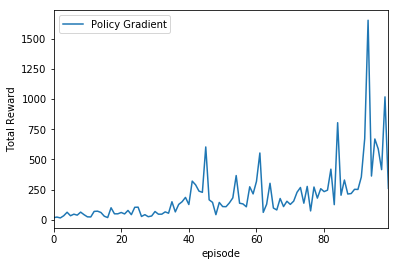

In [6]:
reward_result = pd.DataFrame(step_record)
reward_result.columns = ['Policy Gradient']
reward_result.plot()
plt.xlabel('episode')
plt.ylabel('Total Reward')
plt.show()